<img src='media/penguin.gif' align='center' width="200px">

# Analysis of Food Products

**Topic**: Analysis of food products from [Perekrestok](https://www.perekrestok.ru)

**Main Goal**: To determine if there is a correlation between the product description, ingredients, and price.

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest

import parcer

## Data Collection

We will begin data collection from the [catalog page](https://www.perekrestok.ru/cat), gradually diving deeper.

All parsing functions are located in `parcer.py`.

**Step 1** \
Collect all product categories and their respective links.

In [4]:
cats = parcer.parce_cats("https://www.perekrestok.ru/cat") # /ᐠ｡ꞈ｡ᐟ\
cats[0]

['Снова в школу', '/cat/mc/1269/snova-v-skolu']

We'll remove categories that do not pertain to food products.

In [8]:
undesired_cats = [
    'Все на дачу',
    'Зоотовары',
    'Для дома и дачи',
    'Красота, гигиена, аптека',
    'Уборка',
    'Товары для мам и детей',
    'Системы нагревания, табак',
    'Посуда',
]

cats = [cat for cat in cats if cat[0] not in undesired_cats]

**Step 2** \
Using the category links, collect subcategories and their respective links.

In [10]:
subcats = parcer.parce_subcats(cats)
subcats[0]

('Зелёная Линия', 'От Перекрёстка', '/cat/c/284/zelenaa-linia')


We'll remove subcategories that do not pertain to food products.


In [11]:
undesired_subcats = [
    'Home Story',
    'Kokoro',
    'Honey Kid',
]

subcats = [subcat for subcat in subcats if subcat[0] not in undesired_subcats]


**Step 3** \
Now, using the subcategory links, we can gather all listings. Listings contain links to products as well as basic information.

In [34]:
listing_products = parcer.parce_listing_products(subcats)
listing_products[0]

['Томаты черри на ветке, 250г',
 '/cat/150/p/tomaty-cerri-na-vetke-250g-3673307',
 'От Перекрёстка',
 'Маркет',
 '4.92',
 '250 гр',
 '179,99 ₽/шт',
 '179,99 ₽',
 '219,99 ₽',
 '-18%',
 '/cat/c/287/market']

In [72]:
parcer.save_listing_products_to_csv('data/listing_products.csv', listing_products)

Список успешно сохранен в файл data/listing_products.csv



**Step 4** \
Go through the links from the listings to obtain complete information about each product.

In [75]:
products = parcer.parce_products(listing_products)
products[0]

['/cat/150/p/tomaty-cerri-na-vetke-250g-3673307',
 'Томаты черри на ветке, 250г',
 17999,
 '-18%',
 492,
 '15.0',
 '0.8 г',
 '0.1 г',
 '2.8 г',
 'Томаты.',
 'ТД Самарканд Агро',
 'Маркет',
 'Россия',
 '30 дней',
 '15 ℃',
 '5 ℃']

In [67]:
parcer.save_products_to_csv('data/products.csv', products)

Список успешно сохранен в файл data/products.csv


**Result** \
In the files *listing_products.csv* and *products.csv*, we've collected information about all products in the relevant categories.

*listing_products.csv* \
`name` - Product name \
`href` - Product link \
`rating` - Product rating from 0.00 to 5.00 \
`size` - Product weight in grams \
`price` - Product pricing (x/unit or x/kg) \
`new_price` - Product price \
`old_price` - Price without discount \
`discount` - Discount or special offer \
`subcat_href` - Subcategory link \
`cat` - Product category \
`subcat` - Product subcategory

*products.csv* \
`title` - Product name \
`product_href` - Product link \
`price` - Product price \
`discount` - Discount or special offer \
`rating` - Product rating from 0.00 to 5.00 \
`kalories` - Calories per 100g \
`proteins` - Proteins per 100g \
`fats` - Fats per 100g \
`carbohydrates` - Carbohydrates per 100g \
`composition` - Product composition \
`manufacturer` - Manufacturer \
`brand` - Brand \
`country` - Country of origin \
`shelf_life` - Shelf life in days \
`max_storage_temperature` - Maximum storage temperature \
`min_storage_temperature` - Minimum storage temperature

## Preprocessing


**Step 1** \
Merge the collected data and remove unnecessary columns.

In [97]:
listing_products_df = pd.read_csv("data/listing_products.csv")
products_df = pd.read_csv("data/products.csv")

df = pd.merge(
    products_df,
    listing_products_df,
    left_on="product_href",
    right_on="href",
    how="left",
)
df = df.drop(
    ["price_x", "discount_x", "title", "product_href", "subcat_href", "rating_x"],
    axis=1,
)


Rename the columns after merging and sort the data.

In [98]:
new_names = {
    "rating_y": "rating",
    "price_y": "pricing",
    "discount_y": "discount",
    "new_price": "price",
    "cat": "category",
    "subcat": "subcategory",
}

df = df.rename(columns=new_names)

new_order = [
    "name",
    "category",
    "subcategory",
    "href",
    "kalories",
    "proteins",
    "fats",
    "carbohydrates",
    "composition",
    "manufacturer",
    "brand",
    "country",
    "rating",
    "size",
    "pricing",
    "price",
    "old_price",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
]

df = df.reindex(columns=new_order)


In some categories, products were duplicated, so we'll fix that.

In [99]:
df.drop_duplicates(inplace=True, subset=['href', 'name'])
df.dropna(subset=['href'], inplace=True)
df = df.drop(['href'], axis=1) # Удаляем больше не нужную колонку
df = df.reset_index(drop=True)
df.head()

,name,category,subcategory,kalories,proteins,fats,carbohydrates,composition,manufacturer,brand,country,rating,size,pricing,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature
0,Вино Мысхако Quintessence Zinfandel красное по...,Алкогольные напитки,Вино,95.0,0.0 г,0.0 г,0.6 г,"Виноград сорта Зинфандель, пищевая добавка (ко...",Мысхако,Мысхако,Россия,4.89,750 мл,"899,99 ₽/шт","899,99 ₽","899,99 ₽",3 по цене 2-х,9999 дней,20 ℃,5 ℃
1,"Вино Takar Арени красное сухое 14%, 750мл",Алкогольные напитки,Вино,74.0,0.0 г,0.0 г,0.3 г,Виноград сорта Арени; пищевая добавка (консерв...,Armenia Wine,Takar,Армения,4.90,750 мл,"699,99 ₽/шт","699,99 ₽","899,99 ₽",-22%,9999 дней,NaN,5 ℃
2,"Вино Terras de Pegoes красное сухое 12.5%, 750мл",Алкогольные напитки,Вино,75.0,0.0 г,0.0 г,0.1 г,"Сортовой состав винограда: Каштелао - 60%, Али...",Cooperativa Agrícola de Santo Isidro De Pegões,Pegoes,Португалия,4.78,750 мл,"499,99 ₽/шт","499,99 ₽","699,99 ₽",-28%,9999 дней,NaN,NaN
3,"Вино Highway to Hell красное сухое 13%, 750мл",Алкогольные напитки,Вино,79.0,0.0 г,0.0 г,0.0 г,"Виноград сорта Монастрель, пищевая добавка (ко...",Wines N'Roses,Highway to Hell,Испания,4.81,750 мл,"1 099,00 ₽/шт","1 099,00 ₽",NaN,Нет скидки,9999 дней,NaN,5 ℃
4,"Вино Don Garcia красное сухое 11%, 1л",Алкогольные напитки,Вино,0.0,0.0 г,0.0 г,0.0 г,"Красные сорта винограда, пищевая добавка (конс...",J. Garcia Carrion,Don Garcia,Испания,4.75,1000 мл,"549,99 ₽/шт","549,99 ₽",NaN,Нет скидки,9999 дней,20 ℃,5 ℃



**Step 2** \
Check for missing values in the dataset.

In [100]:
df.isnull().sum()

name                          0
category                      0
subcategory                   0
kalories                    267
proteins                    308
fats                        308
carbohydrates               313
composition                 332
manufacturer                398
brand                       532
country                     238
rating                        0
size                        692
pricing                       0
price                         0
old_price                  8989
discount                      0
shelf_life                    0
max_storage_temperature    3777
min_storage_temperature    4627
dtype: int64


Remove non-food items that were included in the dataset due to mixed categories. \
To do this, identify all products with missing `kalories` and exclude non-food items from them.

In [101]:
non_food_ids = (df["kalories"].isnull()) & (
    ~df["subcategory"].isin(
        [
            "Кофе",
            "Чай",
            "Специи, приправы и пряности",
            "Соль",
            "Вся рыба",
            "Охлаждённая рыба",
            "Копчёная рыба",
            "Вяленая рыба",
            "Вода",
            "Пиво",
            "Конфеты",
            "Компоненты для выпечки",
            "Молочные коктейли",
            "Полуфабрикаты",
            "Овощи",
            "Фрукты",
            "Зелень и салаты",
            "Коньяк",
        ]
    )
)

non_food = df[non_food_ids][["name", "subcategory"]]
df = df[~non_food_ids]

non_food.iloc[5]

name           Губка Волна для обуви и изделий из кожи бесцве...
subcategory                                               Маркет
Name: 6154, dtype: object


Fill all other missing `kalories` with zeros.

In [102]:
df.loc[df['kalories'].isnull(), 'kalories'] = 0


**Step 3** \
Convert `proteins`, `fats`, and `carbohydrates` to float type and fill missing values with zeros.

In [103]:
df.loc[:, 'proteins'] = df['proteins'].str.replace(' г', '').astype(float)
df.loc[:, 'fats'] = df['fats'].str.replace(' г', '').astype(float)
df.loc[:, 'carbohydrates'] = df['carbohydrates'].str.replace(' г', '').astype(float)

df.loc[df['proteins'].isnull(), 'proteins'] = 0
df.loc[df['fats'].isnull(), 'fats'] = 0
df.loc[df['carbohydrates'].isnull(), 'carbohydrates'] = 0


**Step 4** \
Since we don't have information on the average density of all beverages, implicitly equate **ml** to **grams** in the `size` column and convert it to float.

In [104]:
df.loc[:, "size"] = (
    df["size"]
    .str.replace(" гр", "")
    .str.replace(" мл", "")
    .str.replace(" ", "")
    .astype(float)
)


For bulk products 🥒, the `pricing` is listed per **kg** instead of **unit**, so the `size` in these rows is empty. \
Fill these missing values as 1000 grams, and also create a **new feature** called `is_by_weight` to indicate whether the product is sold by weight.
<a id='is_by_weight'></a>

In [105]:
pricing_units = df["pricing"].str.split("/").str[1]
pricing_units.unique()

array(['шт', 'кг'], dtype=object)

In [106]:
df.loc[pricing_units == "кг", "size"] = 1000
df["is_by_weight"] = 1 * (pricing_units == "кг")


Afterward, `pricing` will no longer be needed, as we have `price`.

In [107]:
df = df.drop(['pricing'], axis=1) 


Format `price` and `old_price`.

In [108]:
df.loc[:, "price"] = (
    df["price"]
    .str.replace(" ₽", "")
    .str.replace(",", ".")
    .str.replace(" ", "")
    .astype(float)
)
df.loc[:, "old_price"] = (
    df["old_price"]
    .str.replace(" ₽", "")
    .str.replace(",", ".")
    .str.replace(" ", "")
    .astype(float)
)


For products without discounts, the `old_price` attribute is missing, so we'll set it equal to `price`.

In [109]:
null_old_prices = df['old_price'].isnull()
df.loc[null_old_prices, 'old_price'] = df[null_old_prices]['price']


**Step 5** \
Convert the discount to float, and for special offers, create a **new feature** called `is_special_offer`.
<a id='is_special_offer'></a>


In [110]:
df['discount'].unique()

array(['3 по цене 2-х', '-22%', '-28%', 'Нет скидки', '-25%', '-33%',
       '-16%', '-18%', '-41%', '-17%', '-26%', '-43%', '-15%', '-19%',
       '-31%', '-23%', '-44%', '-57%', '-36%', '-37%', '-40%', '-30%',
       '-24%', '-47%', '-55%', '-27%', '-21%', '-49%', '-14%', '-45%',
       '-11%', '-56%', '-48%', 'Новинка', '-20%', '-32%', '-52%', '-38%',
       '-50%', '-29%', '-13%', '-10%', '-39%', '-35%', '-46%', '-12%',
       'Низкая цена', '-58%', '-34%', '-54%', '-42%', '-65%', '-62%',
       '-59%', '-53%', '-63%', '-70%', '-51%', '5 по цене 4-х',
       '2 по цене 1-го', '-60%', '4 по цене 3-х', '-77%'], dtype=object)

In [111]:
is_special_offer = df["discount"].isin(
    [
        "3 по цене 2-х",
        "Новинка",
        "Низкая цена",
        "5 по цене 4-х",
        "2 по цене 1-го",
        "4 по цене 3-х",
    ]
)

is_no_discount = df["discount"].isin(["Нет скидки"])

df.loc[:, "discount"] = df["discount"].str.replace("-", "").str.replace("%", "")
df.loc[is_special_offer + is_no_discount, "discount"] = 0
df.loc[:, "discount"] = df["discount"].astype(float)

df["is_special_offer"] = is_special_offer


**Step 6** \
Convert `shelf_life`, `max_storage_temperature`, and `min_storage_temperature` to float type.

In [112]:
df.loc[:, "shelf_life"] = (
    df["shelf_life"]
    .str.replace(" дней", "")
    .str.replace(" день", "")
    .str.replace(" дня", "")
    .astype(float)
)
df.loc[:, "max_storage_temperature"] = (
    df["max_storage_temperature"].str.replace(" ℃", "").astype(float)
)
df.loc[:, "min_storage_temperature"] = (
    df["min_storage_temperature"].str.replace(" ℃", "").astype(float)
)

For some products, the maximum and minimum storage temperature values are swapped, so we'll correct that.

In [113]:
mis_tems = df['max_storage_temperature'] < df['min_storage_temperature']

df.loc[mis_tems, ['max_storage_temperature', 'min_storage_temperature']] = \
    df.loc[mis_tems, ['min_storage_temperature', 'max_storage_temperature']].values


We'll treat missing values as an indication of unlimited storage temperature. \
Fill missing `max_storage_temperature` with the maximum value (excluding the single outlier 🍾 at 9999) and `min_storage_temperature` with the minimum value.


In [114]:
sorted(df['max_storage_temperature'].dropna().unique())[-3:]

[40.0, 50.0, 9999.0]

In [115]:
sorted(df['min_storage_temperature'].dropna().unique())[:3]

[-40.0, -30.0, -26.0]

In [116]:
df[df['max_storage_temperature'] == 9999]

,name,category,subcategory,kalories,proteins,fats,carbohydrates,composition,manufacturer,brand,...,rating,size,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature,is_by_weight,is_special_offer
4531,"Коньяк Старая Площадь КВ выдержанный 40%, 500мл",Алкогольные напитки,Коньяк,230.0,0.0,0.0,1.2,Дистилляты коньячные выдержанные не менее сем...,Мосазервинзавод,СТАРАЯ ПЛОЩАДЬ,...,0.0,500.0,779.99,779.99,0.0,9999.0,9999.0,5.0,0,False


In [117]:
max_mask = (df['max_storage_temperature'] == 9999) + df['max_storage_temperature'].isnull()
df.loc[max_mask, 'max_storage_temperature'] = 50.0

min_mask = df['min_storage_temperature'].isnull()
df.loc[min_mask, 'min_storage_temperature'] = -40.0


**Step 7** \
Fill missing values in `manufacturer`, `brand`, and `country` with "Unknown".


In [118]:
df['manufacturer'] = df['manufacturer'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')


**Step 8** \
For some products, the composition is missing or consists of placeholders like "." or "/". We'll fill these as "Unknown".


In [119]:
df['composition'] = df['composition'].fillna('Unknown')
df.loc[df['composition'] == ".", 'composition'] = 'Unknown'
df.loc[df['composition'] == "/", 'composition'] = 'Unknown'


Update the column types in the dataframe and check for any remaining missing values.


In [120]:
numeric_cols = [
    "proteins",
    "fats",
    "carbohydrates",
    "size",
    "price",
    "old_price",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
]
df[numeric_cols] = df[numeric_cols].astype(float)
df.isnull().sum()

name                       0
category                   0
subcategory                0
kalories                   0
proteins                   0
fats                       0
carbohydrates              0
composition                0
manufacturer               0
brand                      0
country                    0
rating                     0
size                       0
price                      0
old_price                  0
discount                   0
shelf_life                 0
max_storage_temperature    0
min_storage_temperature    0
is_by_weight               0
is_special_offer           0
dtype: int64


**Outliers** \
We’ve addressed the outliers in `max_storage_temperature`, now let’s examine the rest.

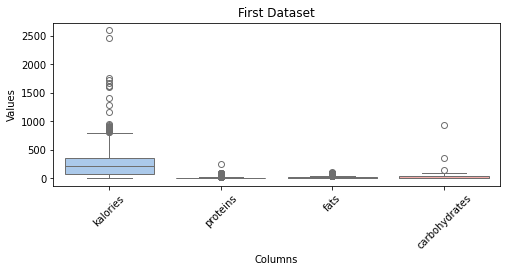

In [121]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=df[['kalories', 'proteins', 'fats', 'carbohydrates']])
plt.title('First Dataset')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


Handle the cases of super-protein ice cream and super-caloric crackers.


In [122]:
x10_outliers = df['kalories'] > 1100
print(df[x10_outliers][['name', 'kalories']].iloc[4])
df.loc[x10_outliers, 'kalories'] = df['kalories'][x10_outliers] / 10

name        Хлебцы Magic Grain мультизлаковые тыквенные се...
kalories                                               1610.0
Name: 9031, dtype: object


In [123]:
vodka_outliers = df['kalories'] > 919
print(df[vodka_outliers][['name', 'kalories']])
df.loc[vodka_outliers, 'kalories'] = df['kalories'][vodka_outliers] / (df['size'][vodka_outliers]/100)

                                                   name  kalories
3890           Сыр Pretto творожный с огурцом 65%, 140г     942.6
6910                       Водка Гусь Важный 40%, 500мл     920.0
7044  Водка Kremlin Award Органик Лимитед Эдишн 40%,...     940.0


In [124]:
icecream_outliers = df['proteins'] > 249
print(df[icecream_outliers][['name', 'proteins']])
df.loc[icecream_outliers, 'proteins'] = df['proteins'][icecream_outliers] / 10

                                                    name  proteins
11611  Мороженое сливочное Brand Ice Сливки с печенье...     250.0


In [125]:
fats_outliers = df['fats'] > 105
print(df[fats_outliers][['name', 'fats']])
df.loc[fats_outliers, 'fats'] = df['fats'][fats_outliers] / 10

                                     name   fats
5863  Гранола Ягодная Зелёная Линия, 300г  106.0


In [126]:
icecream_outliers = df['carbohydrates'] > 105
print(df[icecream_outliers][['name', 'carbohydrates']])
df.loc[icecream_outliers, 'carbohydrates'] = df['carbohydrates'][icecream_outliers] / 10

                                      name  carbohydrates
3619            Сыр Киприно Российский 50%          360.0
6405                 Водка CORN 40%, 500мл          930.0
10393  Конфеты ассорти Зелёная Линия, 200г          153.3


<img src='media/milk.gif' align='center' width="200px">


**Result** \
There are no missing values in the data, and it has been formatted and cleaned of outliers.

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12399 entries, 0 to 12598
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     12399 non-null  object 
 1   category                 12399 non-null  object 
 2   subcategory              12399 non-null  object 
 3   kalories                 12399 non-null  float64
 4   proteins                 12399 non-null  float64
 5   fats                     12399 non-null  float64
 6   carbohydrates            12399 non-null  float64
 7   composition              12399 non-null  object 
 8   manufacturer             12399 non-null  object 
 9   brand                    12399 non-null  object 
 10  country                  12399 non-null  object 
 11  rating                   12399 non-null  float64
 12  size                     12399 non-null  float64
 13  price                    12399 non-null  float64
 14  old_price                12

## Visualization


Let's examine the distribution of the variable we will be predicting.


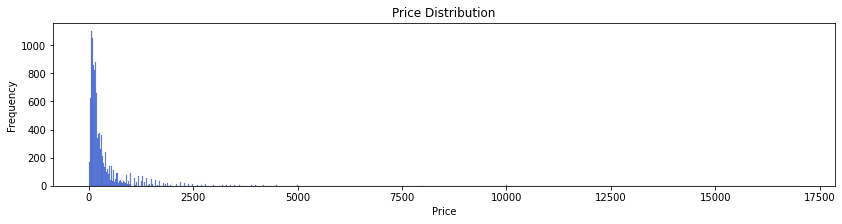

In [142]:
plt.figure(figsize=(14, 3))
sns.histplot(df['price'], color='#3764fa')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

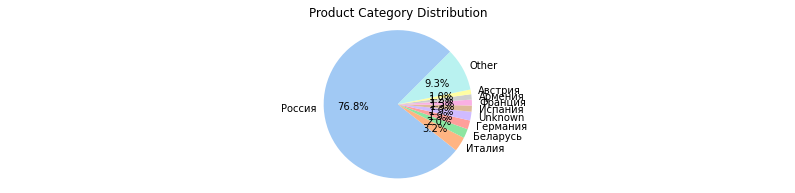

In [143]:
threshold_percentage = 0.8

category_counts = df['country'].value_counts()

small_categories_sum = category_counts[category_counts / category_counts.sum() * 100 < threshold_percentage].sum()
category_counts = category_counts[category_counts / category_counts.sum() * 100 >= threshold_percentage]
category_counts['Other'] = small_categories_sum

plt.figure(figsize=(14, 3))
sns.set_palette("pastel")
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Product Category Distribution')
plt.axis('equal')
plt.show()

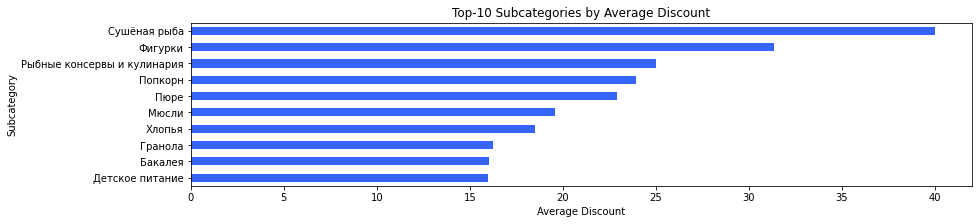

In [144]:
mean_discount_by_subcategory = df.groupby('subcategory')['discount'].mean()

top_10_discount_by_subcategory = mean_discount_by_subcategory.sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 3))
top_10_discount_by_subcategory.plot(kind='barh', color='#3764fa')
plt.title('Top-10 Subcategories by Average Discount')
plt.xlabel('Average Discount')
plt.ylabel('Subcategory')
plt.gca().invert_yaxis()
plt.show()


It appears that discounts are more common for products with a longer shelf life.


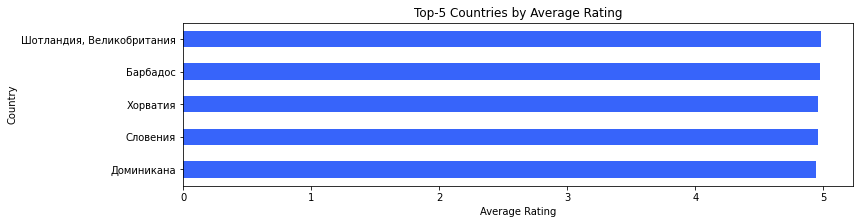

In [145]:
mean_rating_by_country = df.groupby('country')['rating'].mean()

top_15_rating_by_country = mean_rating_by_country.sort_values(ascending=False).head(5)

plt.figure(figsize=(12, 3))
top_15_rating_by_country.plot(kind='barh', color='#3764fa')
plt.title('Top-5 Countries by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Country')
plt.gca().invert_yaxis()
plt.show()

<Axes: >

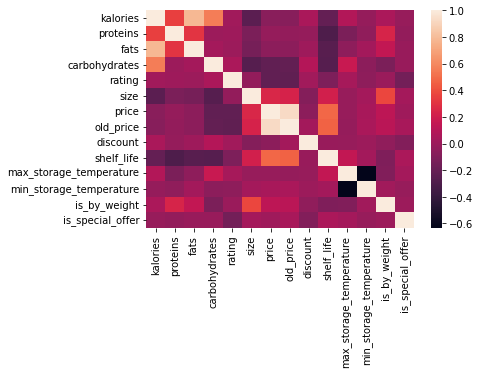

In [146]:
numeric_df = df.drop(['name', 'category', 'subcategory', 'composition', 'manufacturer', 'brand', 'country'], axis=1)
sns.heatmap(numeric_df.corr())


In addition to some expected correlations, such as between calories and macronutrients (proteins, fats, and carbohydrates), it's interesting to note that there is a correlation between shelf life and price, as well as a slightly weaker correlation between protein content and whether a product is sold by weight.

Let's take a look at the highest-calorie products.

<Figure size 1008x576 with 0 Axes>

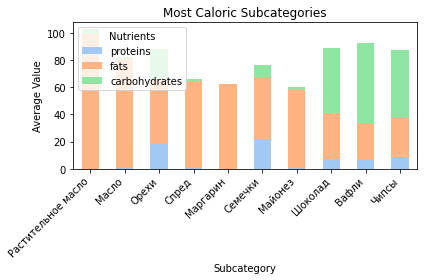

In [147]:
nutrients_by_subcategory = df.groupby('subcategory')[['kalories', 'proteins', 'fats', 'carbohydrates']] \
    .mean().sort_values(by='kalories', ascending=False)[['proteins', 'fats', 'carbohydrates']].head(10)

plt.figure(figsize=(14, 8))
nutrients_by_subcategory.plot(kind='bar', stacked=True)
plt.title('Most Caloric Subcategories')
plt.xlabel('Subcategory')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nutrients', loc='upper left')
plt.tight_layout()
plt.show()


Let's examine the highest-protein products.

<Figure size 1008x576 with 0 Axes>

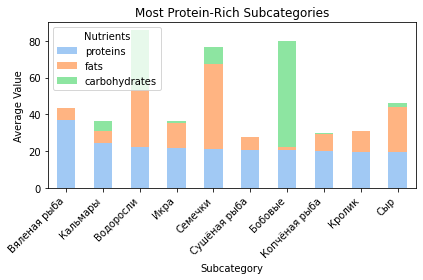

In [148]:

nutrients_by_subcategory = df.groupby('subcategory')[['proteins', 'fats', 'carbohydrates']] \
    .mean().sort_values(by='proteins', ascending=False).head(10)

plt.figure(figsize=(14, 8))
nutrients_by_subcategory.plot(kind='bar', stacked=True)
plt.title('Most Protein-Rich Subcategories')
plt.xlabel('Subcategory')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nutrients', loc='upper left')
plt.tight_layout()
plt.show()

## Feature Engineering


In [149]:
from sklearn.feature_extraction.text import HashingVectorizer

import country_data


`is_by_weight` - Indicates whether the product is sold by weight \
`is_special_offer` - Indicates whether the product has a special offer \
`composition[128]` - Composition in vectorized form

`storage_temp_range` - Storage temperature range \
`protein_to_carb_ratio` - Protein to carbohydrate ratio \
`is_low_carb` - Indicates whether the product is low-carb

`kalories_all` - Total calories \
`proteins_all` - Total proteins \
`fats_all` - Total fats

`is_local` - Indicates whether the product is from Russia \
`country_gdp_per_capita` - Country's GDP per capita



The features [is_by_weight](#is_by_weight) and [is_special_offer](#is_special_offer) were already created during preprocessing, so we'll create the remaining ones.



**Step 1** \
Represent the product composition in vector form using HashingVectorizer.


In [150]:
lines = df['composition'][~df['composition'].isnull()]
vectorizer = HashingVectorizer(n_features=128)
composition_vectors = vectorizer.fit_transform(lines).toarray()


Keep `composition_vectors` as a variable for convenience.



**Step 2** \
Create `storage_temp_range`, `protein_to_carb_ratio`, and `is_low_carb`. \
A product is considered low-carb if the protein-to-carbohydrate ratio is greater than 1.


In [151]:
def calculate_ratio(proteins, carbs):
    if carbs == 0:
        if proteins == 0:
            return 0.0  # NaN
        else:
            return 1e6  # inf 
    return proteins / carbs

df["storage_temp_range"] = df["max_storage_temperature"] - df["min_storage_temperature"]

df["protein_to_carb_ratio"] = df.apply(
    lambda row: calculate_ratio(row["proteins"], row["carbohydrates"]), axis=1
)

df["is_low_carb"] = df["protein_to_carb_ratio"] > 1


**Step 3** \
Create `kalories_all`, `proteins_all`, and `fats_all`.


In [152]:
df['kalories_all'] = df['kalories']/100 * df['size']
df['proteins_all'] = df['proteins']/100 * df['size']
df['fats_all'] = df['fats']/100 * df['size']


**Step 4** \
Obtain `country_gdp_per_capita` using a function from `country_data`. \
Consider everything from Russia as `is_local`.


In [153]:
df['is_local'] = df['country'] == "Россия"

df['country_gdp_per_capita'] = df['country'].apply(
    country_data.get_country_gdp_per_capita
).astype(float)


**Result** \
All new features have been successfully created.

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12399 entries, 0 to 12598
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     12399 non-null  object 
 1   category                 12399 non-null  object 
 2   subcategory              12399 non-null  object 
 3   kalories                 12399 non-null  float64
 4   proteins                 12399 non-null  float64
 5   fats                     12399 non-null  float64
 6   carbohydrates            12399 non-null  float64
 7   composition              12399 non-null  object 
 8   manufacturer             12399 non-null  object 
 9   brand                    12399 non-null  object 
 10  country                  12399 non-null  object 
 11  rating                   12399 non-null  float64
 12  size                     12399 non-null  float64
 13  price                    12399 non-null  float64
 14  old_price                12

## Hypotheses


In [155]:
import statsmodels.api as sm
from scipy import stats


During the project, several questions arose: 
- Does the composition affect the product's rating?
- Does the protein content depend on whether the product is sold by weight?
- Does the price depend on the shelf life?
- Are foreign products more expensive?
- Is it true that discounts are less common for products with a short shelf life?


**Step 1** \
Does the composition affect the product's rating?

$$
\begin{aligned}
&H_0: \text{Composition does not affect the product's rating} \\ 
&H_1: \text{Composition affects the product's rating}
\end{aligned}
$$

We will apply regression analysis.

In [156]:
X = sm.add_constant(composition_vectors)
y = df['rating']

model = sm.OLS(y, X).fit()
p_values = model.pvalues[1:]

alpha = 0.05

is_p_value_alpha = [p_value < alpha for p_value in p_values]
print('Number of p-values < alpha:', sum(is_p_value_alpha), "/", len(is_p_value_alpha))

# If at least one p-value is less than alpha, reject H0
if any(is_p_value_alpha):
    print("H0 is rejected: Composition affects the product rating")
else:
    print("H0 is not rejected: Composition does not affect the product rating")

Number of p-values < alpha: 36 / 128
H0 is rejected: Composition affects the product rating



**Step 2** \
Does the protein content depend on whether the product is sold by weight?

$$
\begin{aligned}
&H_0: \text{Protein content does not depend on whether the product is sold by weight} \\ 
&H_1: \text{Protein content depends on whether the product is sold by weight}
\end{aligned}
$$

We will use a t-test, as the protein values do not follow a normal distribution.


In [157]:
proteins_by_weight = df[df['is_by_weight'] == 1]['proteins']
proteins_not_by_weight = df[df['is_by_weight'] == 0]['proteins']

t_stat, p_value = stats.ttest_ind(proteins_by_weight, proteins_not_by_weight, equal_var=False)

print("t-value:", t_stat)
print("p-value:", p_value)

alpha = 0.05

if p_value < alpha:
    print("H0 is rejected: Protein content depends on whether the product is sold by weight")
else:
    print("H0 is not rejected: Protein content does not depend on whether the product is sold by weight")

t-value: 22.91666008518203
p-value: 1.7609782281645117e-88
H0 is rejected: Protein content depends on whether the product is sold by weight



**Step 3** \
Does the price depend on the shelf life?

$$
\begin{aligned}
&H_0: \text{Price does not depend on shelf life} \\ 
&H_1: \text{Price depends on shelf life}
\end{aligned}
$$

Since the data do not follow a normal distribution and contain outliers, we will use Spearman's correlation coefficient.


In [158]:
corr_test = stats.spearmanr(df['shelf_life'], df['price'])
correlation_coefficient = corr_test[0]
p_value = corr_test[1]

print("Spearman's correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("H0 is rejected: Price depends on shelf life.")
else:
    print("H0 is not rejected: Price does not depend on shelf life.")

Spearman's correlation coefficient: 0.29277953461420597
p-value: 1.3750757732866646e-243
H0 is rejected: Price depends on shelf life.



**Step 4** \
Are foreign products more expensive?

$$
\begin{aligned}
&H_0: \text{Foreign products are not more expensive than local ones} \\ 
&H_1: \text{Foreign products are more expensive than local ones}
\end{aligned}
$$

The U-test is more appropriate than the z-test because it does not require normally distributed data and is suitable for data with outliers. \
It is also appropriate for analyzing data with skewed distributions.


In [159]:
not_unk = ~(df['country'] == "Unknown")

foreign_prices = df[~df['is_local'] & not_unk]['price']
local_prices = df[df['is_local'] & not_unk]['price']

foreign_prices.shape, local_prices.shape

((2635,), (9527,))

In [160]:
u_stat, p_value = stats.mannwhitneyu(foreign_prices, local_prices, alternative='greater')

print("U-statistic:", u_stat)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("H0 is rejected: Foreign products are more expensive than local products")
else:
    print("H0 is not rejected: Foreign products are not more expensive than local products")

U-statistic: 18230106.0
p-value: 6.681267266258801e-278
H0 is rejected: Foreign products are more expensive than local products



**Step 5** \
Is it true that discounts are less common for products with a short shelf life?

$$
\begin{aligned}
&H_0: \text{Products with a short shelf life do not receive discounts more frequently than other products} \\ 
&H_1: \text{Products with a short shelf life receive discounts more frequently than other products}
\end{aligned}
$$

In [161]:
discounted = df[df['discount'] > 0]['shelf_life']
not_discounted = df[df['discount'] == 0]['shelf_life']

u_stat, p_value = stats.mannwhitneyu(discounted, not_discounted, alternative='greater')

print("U-statistic:", u_stat)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("H0 is rejected: Discounts are more common for products with a longer shelf life")
else:
    print("H0 is not rejected: Discounts are not more common for products with a longer shelf life")

U-statistic: 17661316.5
p-value: 2.3882945670061588e-57
H0 is rejected: Discounts are more common for products with a longer shelf life


## Machine Learning

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


**Step 1** \
Let's attempt to predict the price of a product based on its characteristics. \
This could be valuable for manufacturers who want to determine the optimal pricing for their products.


In [163]:
numeric_features = [
    "kalories",
    "proteins",
    "fats",
    "carbohydrates",
    "rating",
    "size",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
    "is_by_weight",
    "is_special_offer",
    "storage_temp_range",
    "protein_to_carb_ratio",
    "is_low_carb",
    "kalories_all",
    "proteins_all",
    "fats_all",
    "country_gdp_per_capita",
]

one_hot_features = ["category", "subcategory", "country"]

target = "price"

X = df[numeric_features]
X = np.concatenate((X, composition_vectors), axis=1)

df_one_hot = pd.get_dummies(df[one_hot_features])
X = np.concatenate((X, df_one_hot), axis=1)

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


We'll exclude unnecessary columns, such as `name`, as well as categorical columns like `manufacturer` and `brand`, so that new manufacturers can rely solely on the product's features when estimating its price.

**Step 2** \
Train several regression models

In [164]:
mse = mean_squared_error(y_test, np.ones(*y_test.shape)*y_train.mean())
mse**0.5

643.5652108337962

In [165]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

predictions = linear_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5

print("LinearRegression")
print("Root Mean Squared Error on the test set:", rmse)

LinearRegression
Root Mean Squared Error on the test set: 428.81672686293774


In [166]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5

print("RandomForestRegressor")
print("Root Mean Squared Error on the test set:", rmse)

RandomForestRegressor
Root Mean Squared Error on the test set: 302.5019031933545


**Conclusion** \
The RandomForest model achieved the best MSE result

In [114]:
_, X_test, _, _ = train_test_split(
    df[['name', 'price']], y, test_size=0.2, random_state=42
)
df_comparison = pd.DataFrame({'Name': X_test['name'], 'Actual Price': X_test['price'], 'Prediction': predictions})
df_comparison.head(10)

,Name,Actual Price,Prediction
2316,Мёд Медовый Дом Крымские травы цветочный натур...,359.99,253.2600
1121,"Горбуша натуральная Пр!ст, 250г",134.99,200.9900
4560,Масло сладкосливочное Традиционное несолёное 8...,219.99,218.9400
11539,Бренди Torres Гран Ресерва 10 38% в подарочной...,1849.00,2148.7198
8664,Хлеб Рижский Хлеб Ремесленный заварной из пшен...,91.99,96.5003
5553,Питахайя крупная,479.99,198.7606
7590,Продукт растительный Kara Coconut Milk на осно...,99.99,181.0600
7953,Маринад Костровок Идея на закуску для приготов...,75.99,98.9600
2417,Десерт Philosophia de Natura Яблочная карамель...,159.99,196.1991
12065,Шоколад горький Лакомства для Здоровья с женьш...,259.99,209.9500
